## Adquisición y preprocesamiento de la información

<table>
    <tr>
      <td>Grado en Ingeniería de Datos e Inteligencia Artificial - Facultad de Informática - UCM
      </td>
      <td>
      <img src="https://biblioteca.ucm.es/data/cont/media/www/pag-88746//escudo.jpg"  width=50/>
      </td>
     </tr>
</table>




# Tratamiento de nulos



### Índice
[Introducción](#Introducción)<br>
[Contando Nulos](#Contando)<br>
[Nulos graficamente](#Graficamente)<br>
[No nulos, pero casi](#Nonulos)<br>
[¿Qué hacer?](#Que)<br>
[Tipos](#Tipos)<br>
  &nbsp;&nbsp;&nbsp;&nbsp;  [MD versus MI en variables categóricas](#Categorical)<br>
  &nbsp;&nbsp;&nbsp;&nbsp;  [MD versus MI en variables ratio](#Ratio)<br>
[Bibliografía](#Bibliografía)<br>

<a name="Intro"></a>
## Introducción

Los valores nulos llamados en inglés *missing* son *huecos* o valores que faltan en nuestro dataset. Puedne impedir que se hagan algunas operaciones o introducir sesgo en otras. Entender por qué surgen y buscar formas de corregirlos es importante para lograr datos de calidad.

<a name="Contando"></a>
## Contando nulos

Los valores nulos se representan mediante la constante NaN que se puede obtener como 

`pd.NA`, `float('nan')`, `math.nan`, or `np.nan`. También el valor `None` se cuenta en Pandas como un valor NaN.




In [ ]:
import numpy as np
import pandas as pd
import math 
df = pd.DataFrame({'a': [1, np.nan, 3, math.nan, float('nan'), None],
                   'b': [1, pd.NA, 3, 4, 6, None],
                   'c': [1, 2, 3, 4, 6, np.nan]})
df

,a,b,c
0,1.0,1,1.0
1,NaN,<NA>,2.0
2,3.0,3,3.0
3,NaN,4,4.0
4,NaN,6,6.0
5,NaN,None,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   a       2 non-null      float64
 1   b       4 non-null      object 
 2   c       5 non-null      float64
dtypes: float64(2), object(1)
memory usage: 272.0+ bytes


Podemos ver los nulos por columnas con el método `isna`

In [ ]:
df.isna().sum()

a    4
b    2
c    1
dtype: int64

Para ver los totales por fila:

In [ ]:
df.isna().sum(axis=1)

0    0
1    1
2    0
3    1
4    1
5    3
dtype: int64

Columnas con algún nulo

In [ ]:
(df.isna().sum() > 0).sum()

3

filas com algún nulo:

In [ ]:
(df.isna().sum(axis=1) > 0).sum()

4

Columnas con todo nulos

In [ ]:
(df.isna().sum() == df.shape[0]).sum()

0

Filas con todo nulos:

In [ ]:
(df.isna().sum(axis=1) == df.shape[1]).sum()

1

Y el total absoluto:

In [ ]:
total = df.isna().sum().sum()
total

5

También es interesante ver la proporción de nulos:

In [ ]:
round(100*total/(df.shape[0]*df.shape[1]),3)

27.778

<a name="Graficamente"></a>
## Nulos gráficamente
Sobre todo en el caso de dataframes con gran cantidad de datos utilizar una visualización adecuada puede ayudar a entender el origen de los nulos

In [ ]:
pip install missingno

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline

titanic = sns.load_dataset("titanic")
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


<AxesSubplot: >

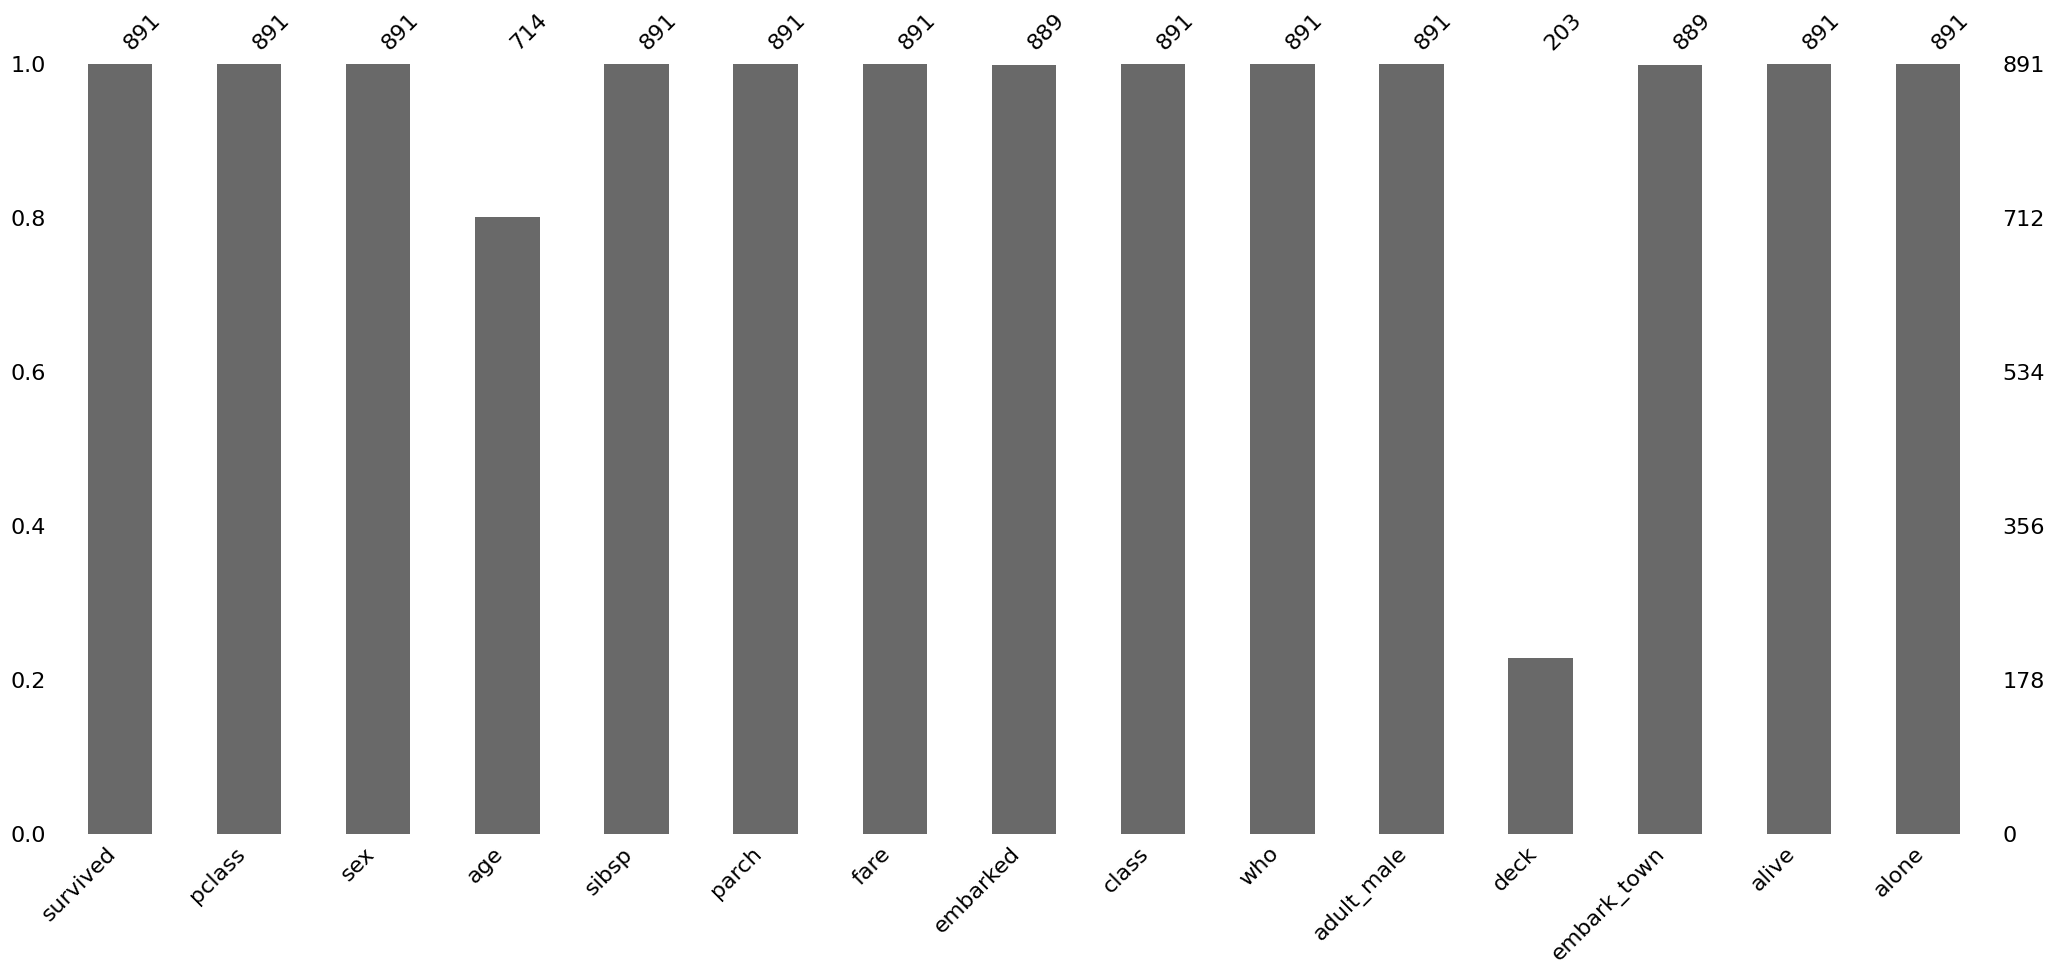

In [ ]:
msno.bar(titanic)

Otra forma de ver lo mismo

<AxesSubplot: >

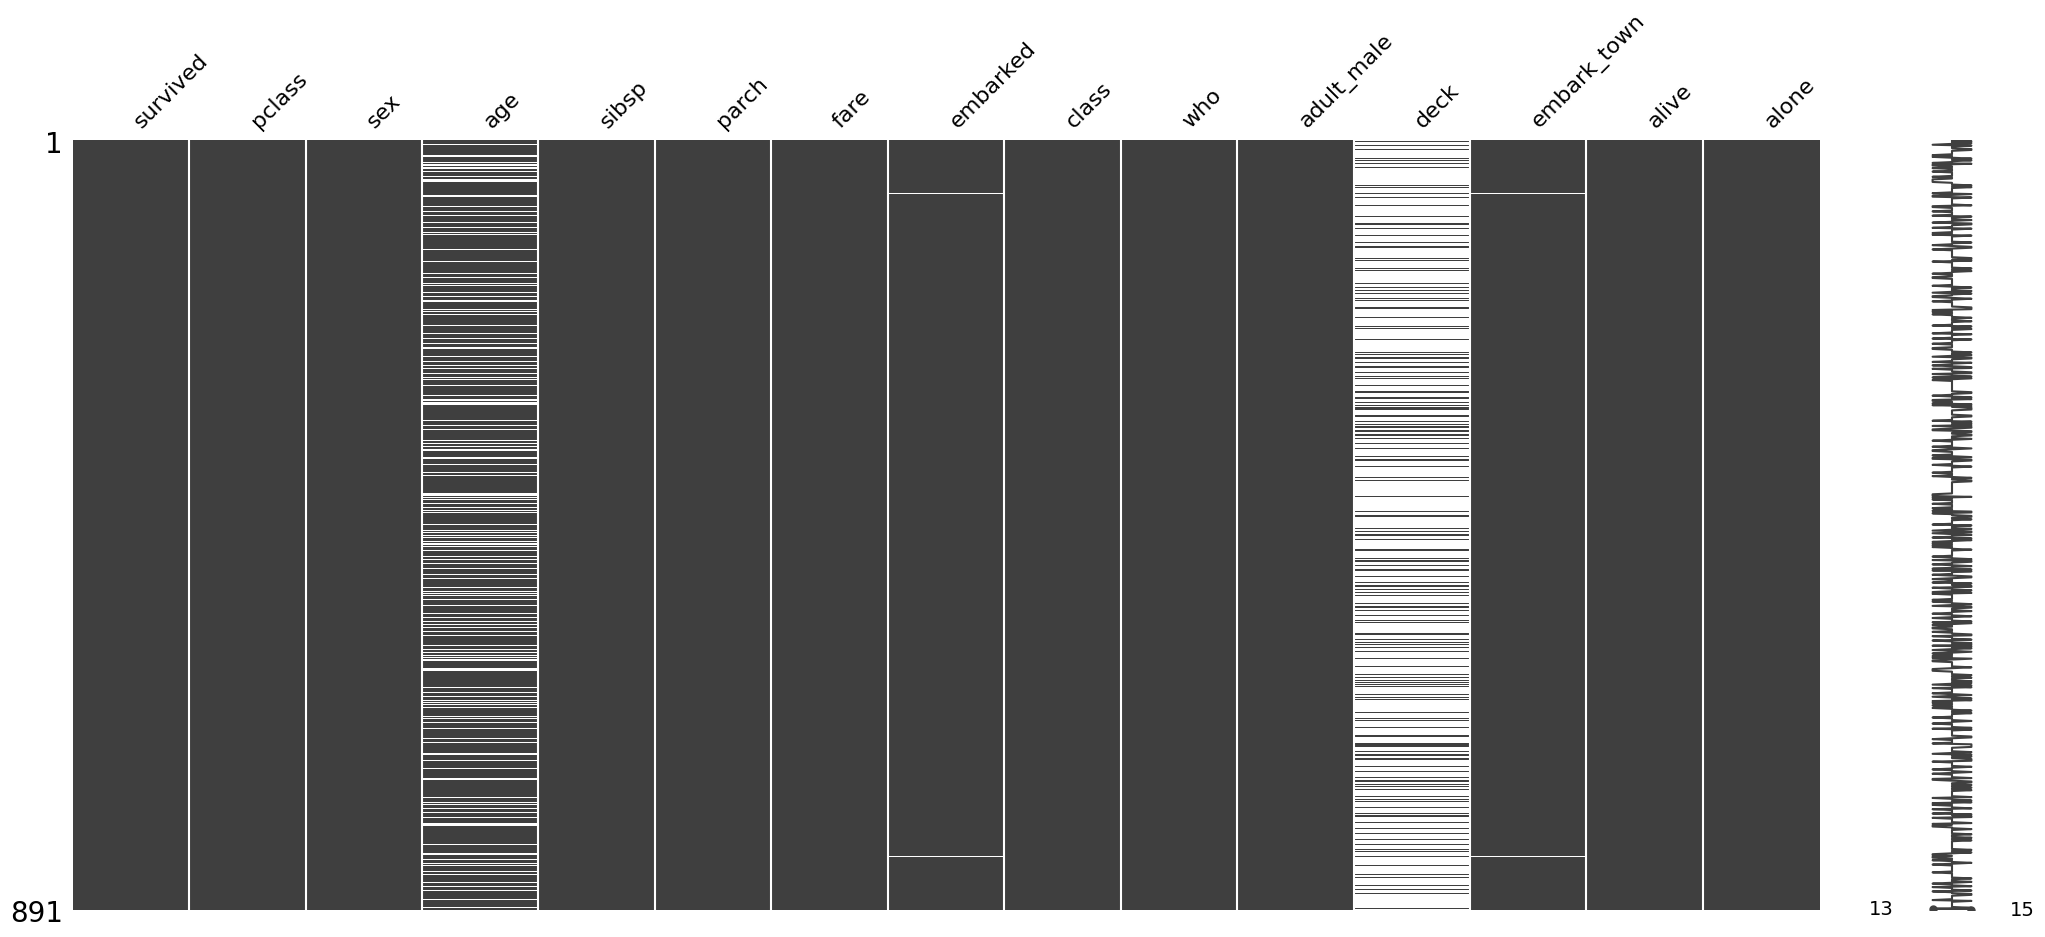

In [ ]:
msno.matrix(titanic)

ESto nos da mucha información y muy útil:

* Parece que solo age y deck tienen nulos. 

* Aparte hay 2 filas que tienen nulos también en `embarked`, `embark_town` (se podrían eliminar?)

El método `heatmap` nos ayudará a relacionar columnas con nulos:

<AxesSubplot: >

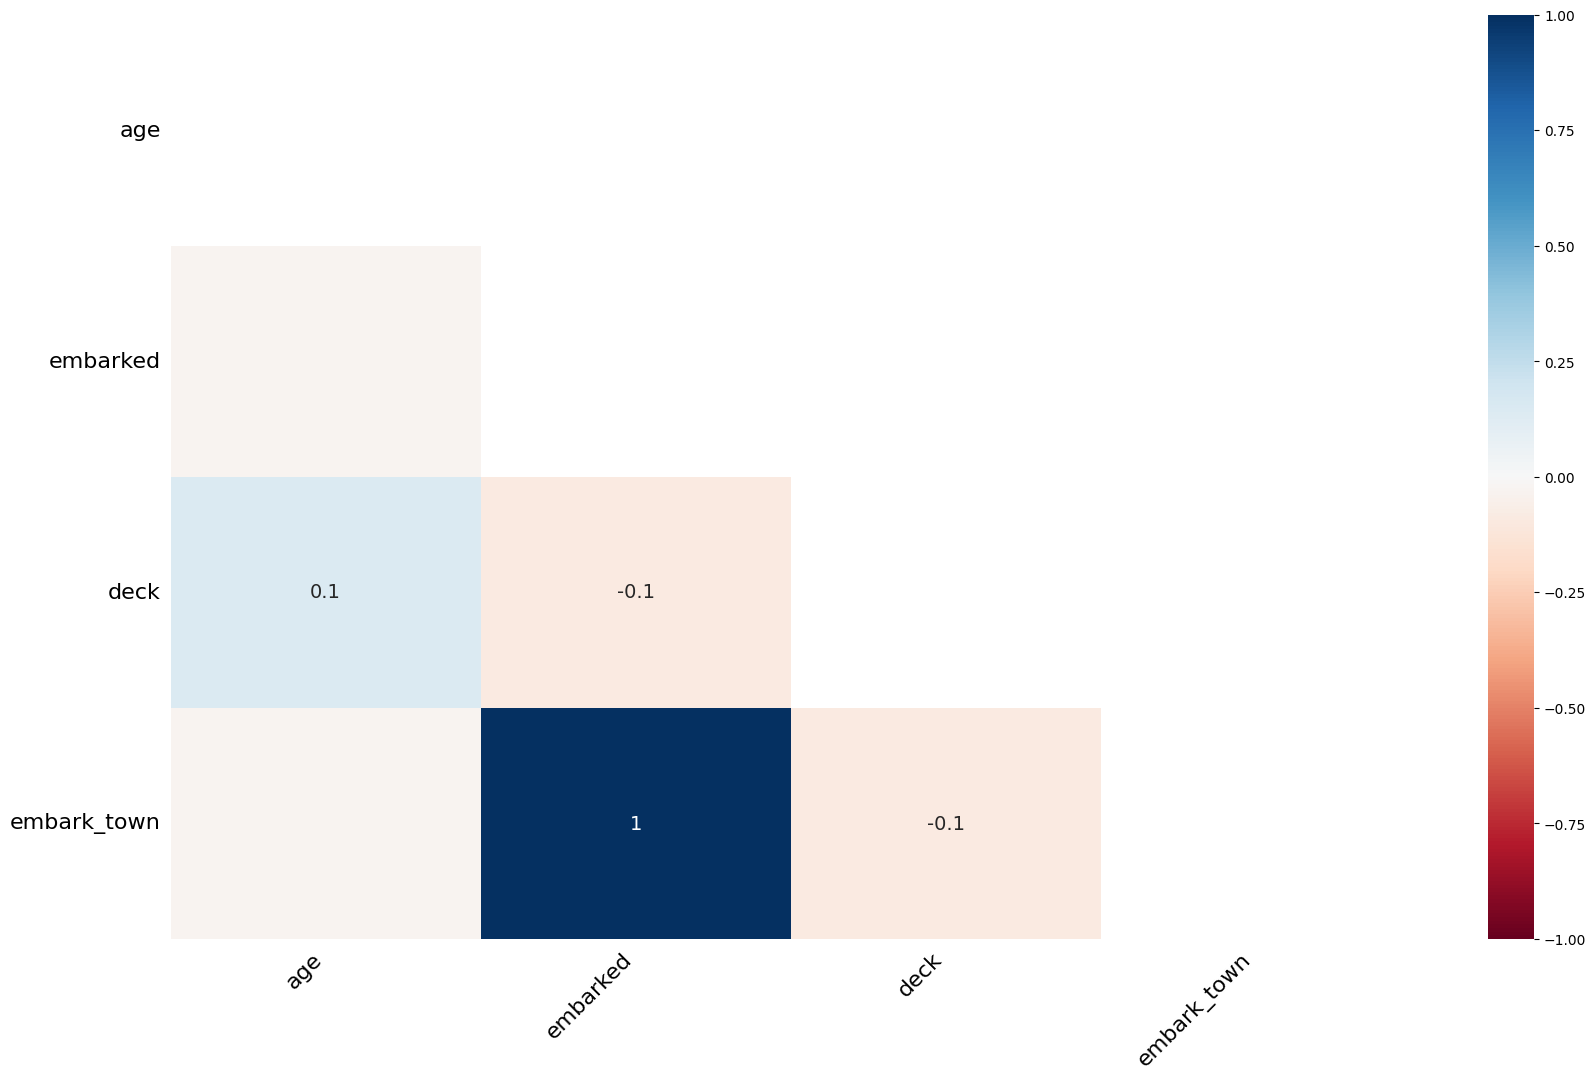

In [ ]:
msno.heatmap(titanic)

Vemos que siempre que embarked es missing también lo es embark_town. 

<a name="Nonulos"></a>
## No nulos, pero casi
En ocasiones hay valores que no son nulos pero son "señales" que indican falta de información. Valores como "99" o valores negativos en columnas que deben tener valores no negativos. Lo que debemos hacer es convertir estos valores en NaN

In [ ]:
url="https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/NATOships.csv"
df2 = pd.read_csv(url)
df2

,course,speed,status,flag,length,beam,lat,long,MMSI
0,178.2,15.9,Under way,Germany,174.0,24.0,38.15398,26.16882,211927000
1,357.1,5.6,-,Spain,96.0,14.0,36.38972,-3.44095,224067000
2,286.9,9.5,-,Spain,NaN,NaN,36.97802,-7.14493,225304000
3,359.9,0.0,-,Spain,NaN,NaN,36.71028,-4.42075,225333000
4,130.5,0.0,-,France,65.0,14.0,-22.29121,166.43580,228762000
...,...,...,...,...,...,...,...,...,...
170,0.9,0.0,-,USA,NaN,NaN,32.67315,-117.12343,338830000
171,30.7,10.4,-,United States (USA),NaN,NaN,-19.21945,146.84966,368921000
172,156.3,11.8,-,United States (USA),NaN,NaN,34.63709,139.79750,368948000
173,105.1,0.0,-,United States (USA),NaN,NaN,54.40621,18.65539,368869000


Queremos reemplazar los valores "-" por NaN

In [ ]:
df2["status"] = df2["status"].replace("-",pd.NA)
df2

,course,speed,status,flag,length,beam,lat,long,MMSI
0,178.2,15.9,Under way,Germany,174.0,24.0,38.15398,26.16882,211927000
1,357.1,5.6,<NA>,Spain,96.0,14.0,36.38972,-3.44095,224067000
2,286.9,9.5,<NA>,Spain,NaN,NaN,36.97802,-7.14493,225304000
3,359.9,0.0,<NA>,Spain,NaN,NaN,36.71028,-4.42075,225333000
4,130.5,0.0,<NA>,France,65.0,14.0,-22.29121,166.43580,228762000
...,...,...,...,...,...,...,...,...,...
170,0.9,0.0,NaN,USA,NaN,NaN,32.67315,-117.12343,338830000
171,30.7,10.4,NaN,United States (USA),NaN,NaN,-19.21945,146.84966,368921000
172,156.3,11.8,NaN,United States (USA),NaN,NaN,34.63709,139.79750,368948000
173,105.1,0.0,NaN,United States (USA),NaN,NaN,54.40621,18.65539,368869000


<AxesSubplot: >

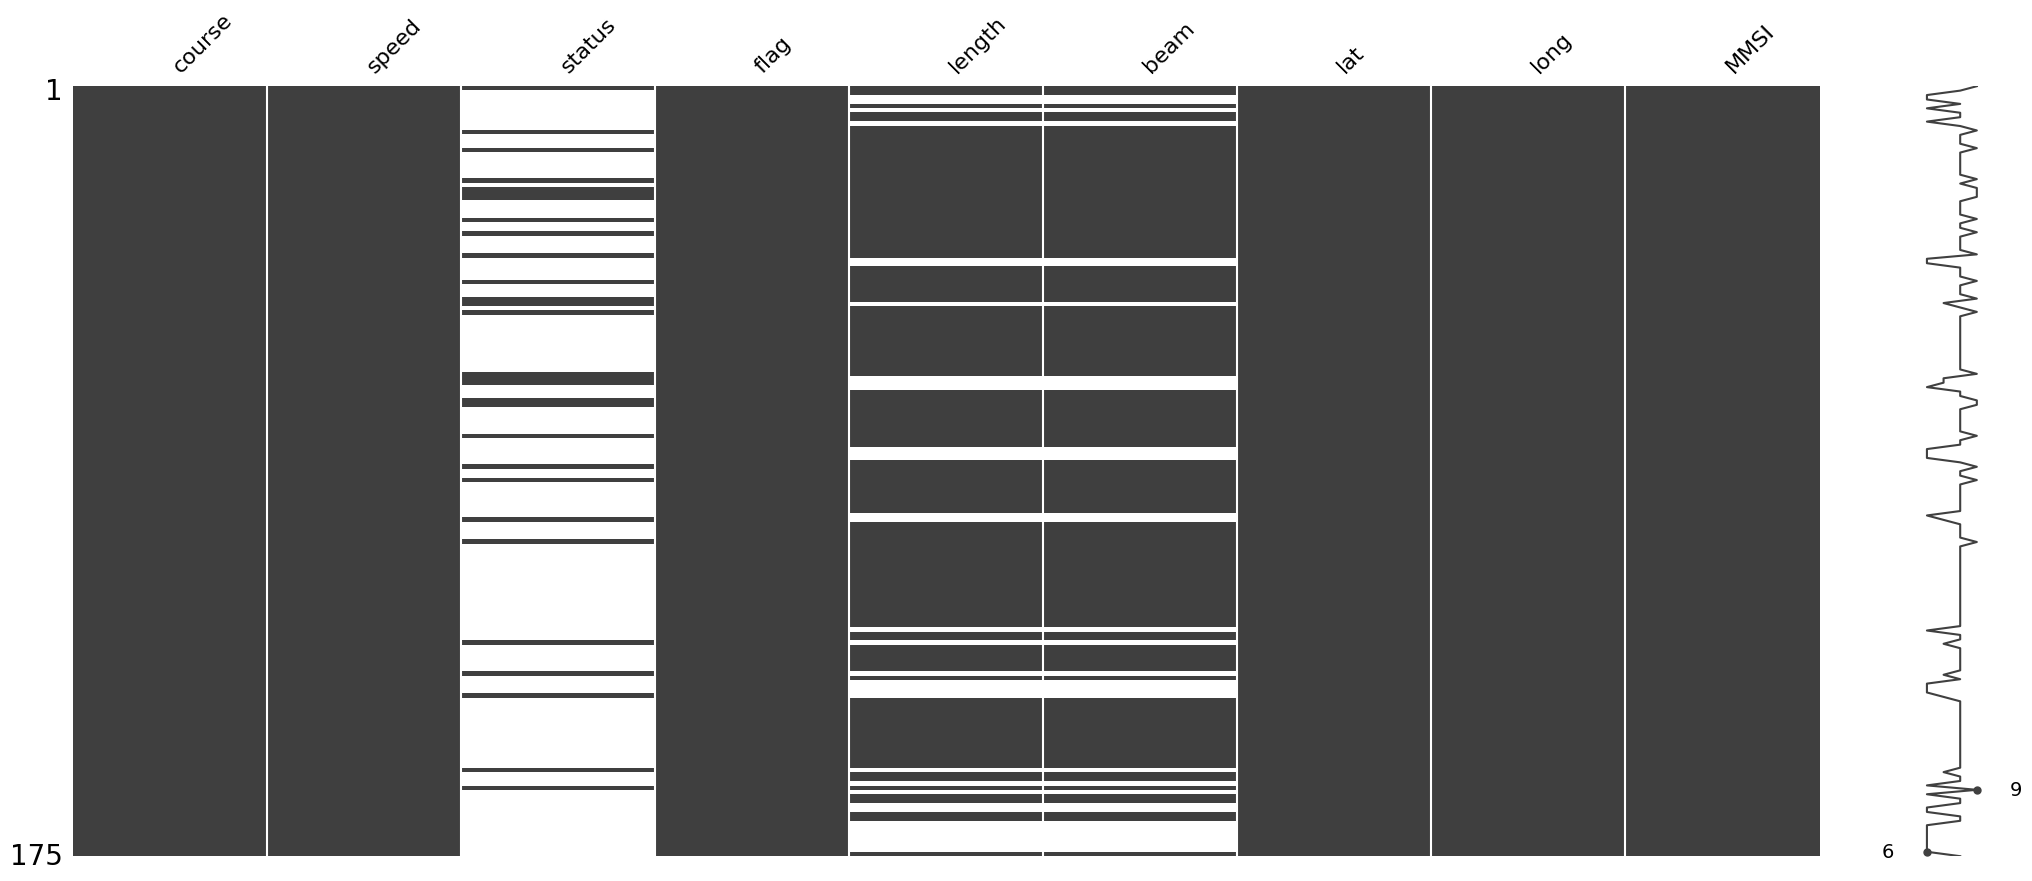

In [ ]:
msno.matrix(df2)

<AxesSubplot: >

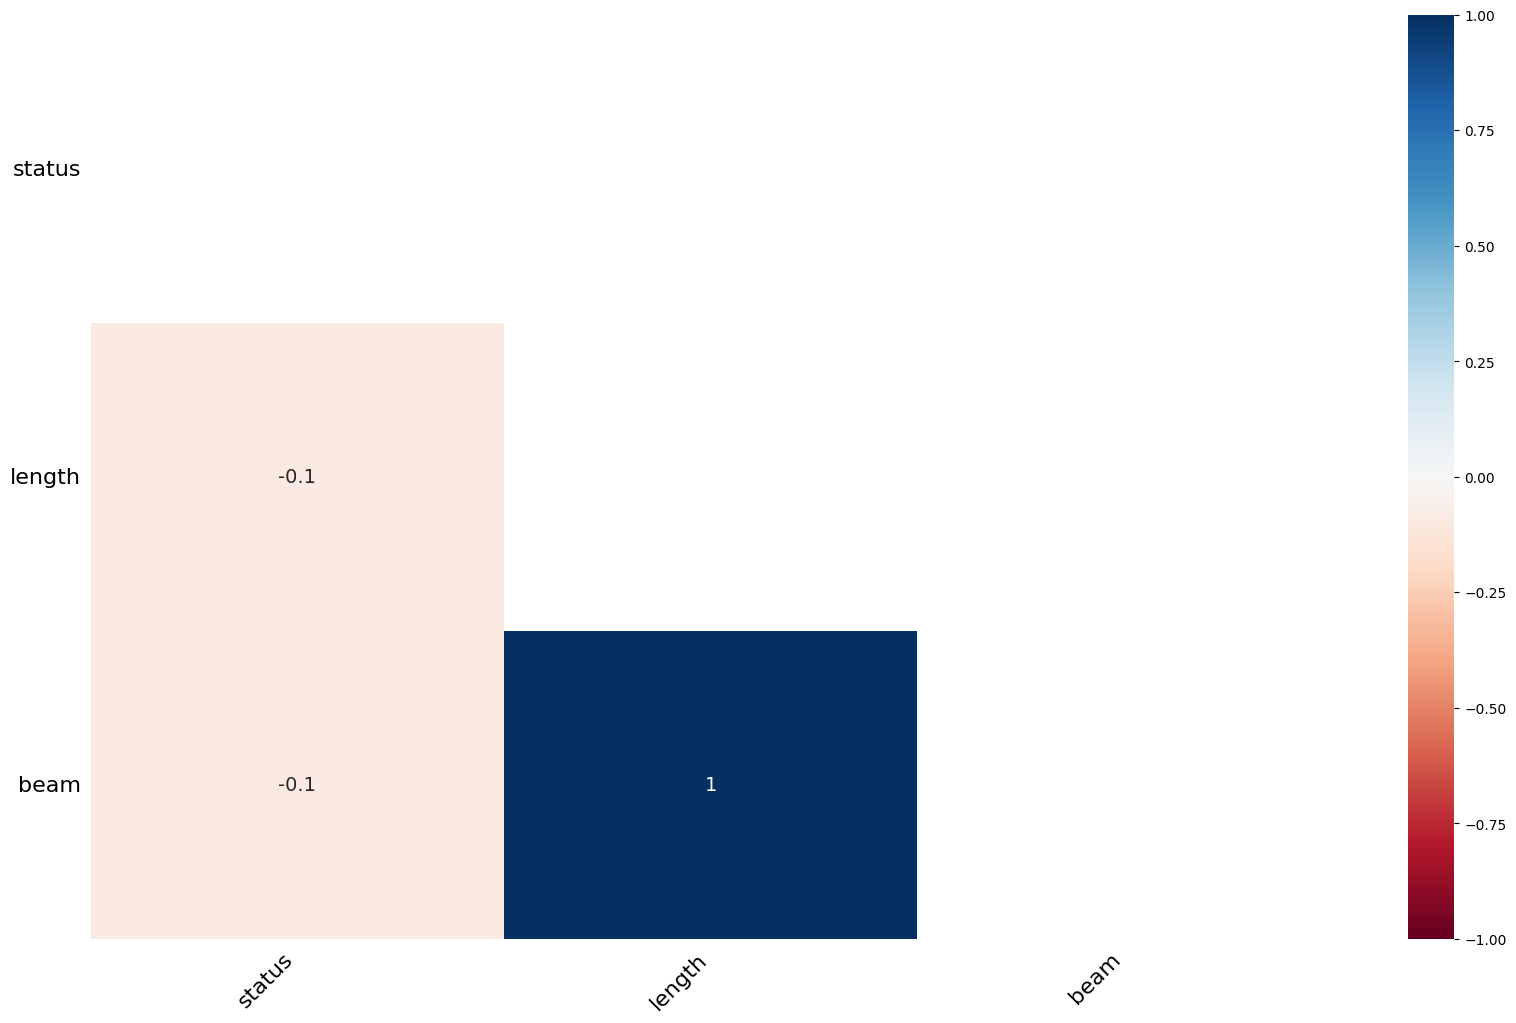

In [ ]:
msno.heatmap(df2)

<a name="Que"></a>
## ¿Qué hacer?

* Si hay columnas con muy pocos datos válidos y que no resultan imprescindibles se pueden borrar

* Si hay muy pocas filas con un valor nulo (representan un tanto por cierto muy pequeño, menor del 1%) se pueden eliminar

* Si el número de nulos es muy alto una posibilidad es *imputar* el valor. Las formas típicas de imputar:
    - La mediana
    - La media
    - La moda (también vale para variables nominales)

<AxesSubplot: >

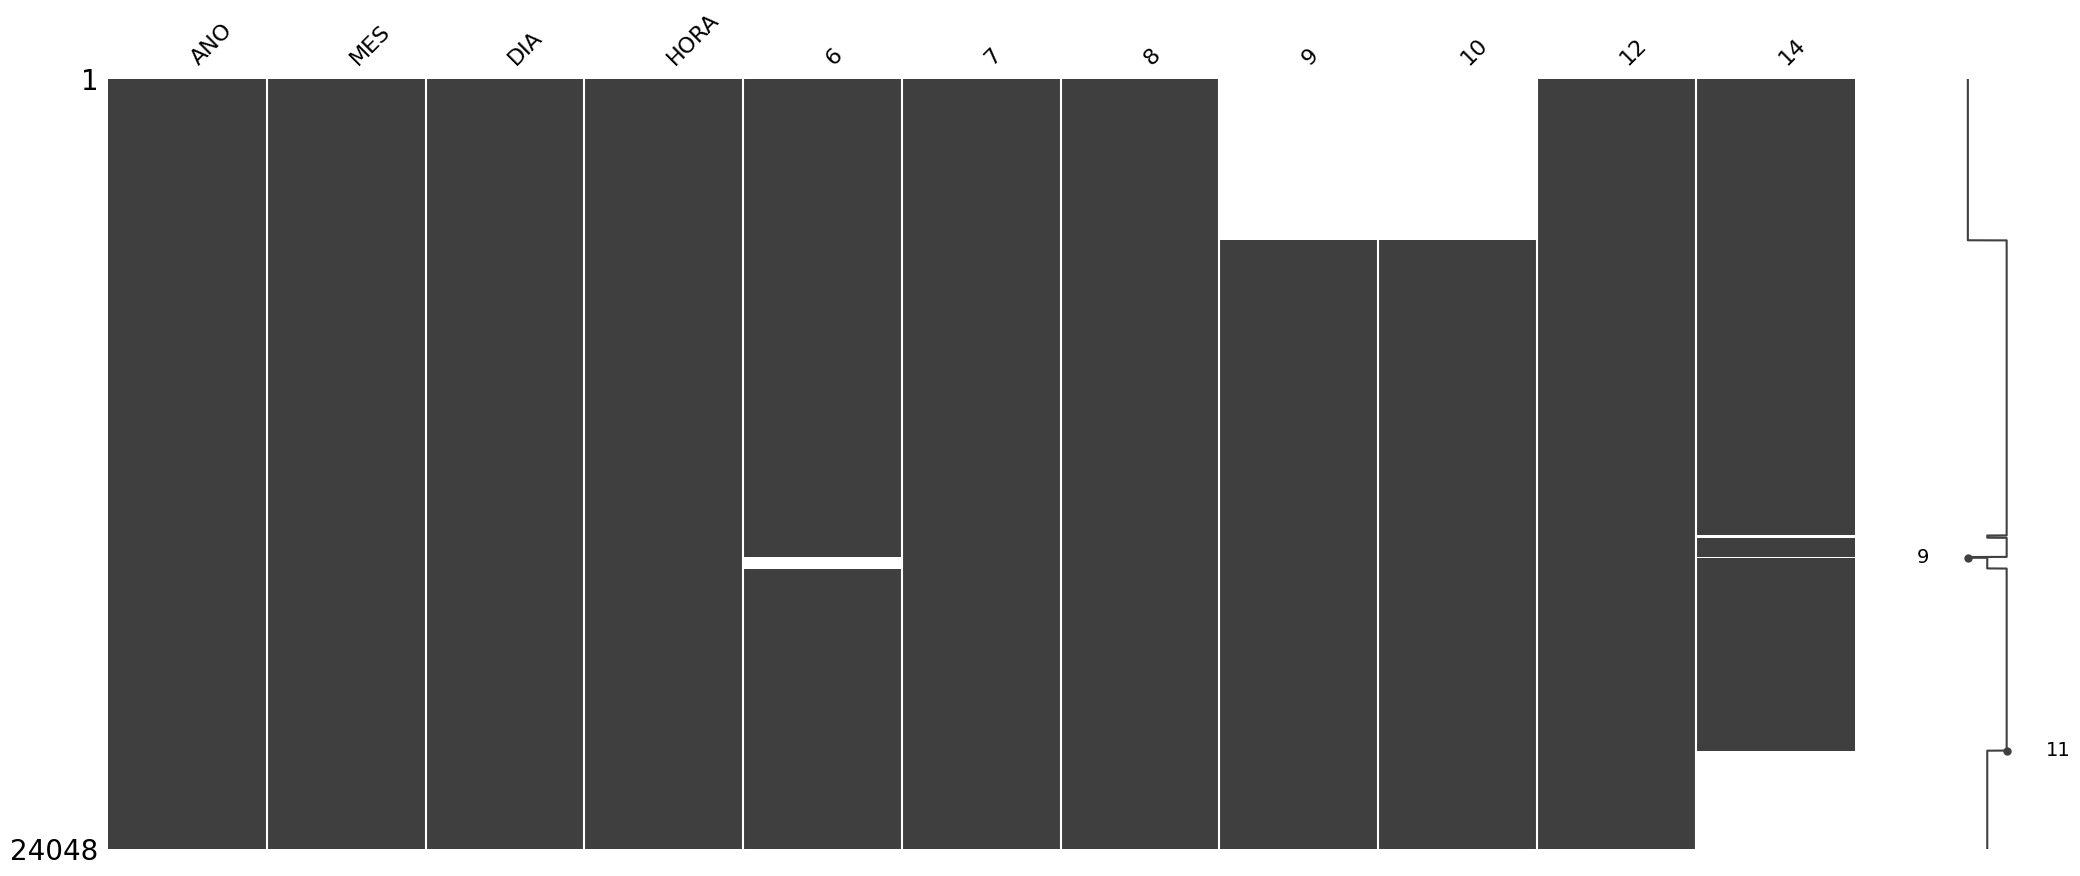

In [ ]:
url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/contaminacionFinal.csv"
df_conta = pd.read_csv(url)
msno.matrix(df_conta)


En la columna 6 queremos reemplazar el valor por el valor medio; para eso utilizaremos un [SimpleImputer}(https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)

<AxesSubplot: >

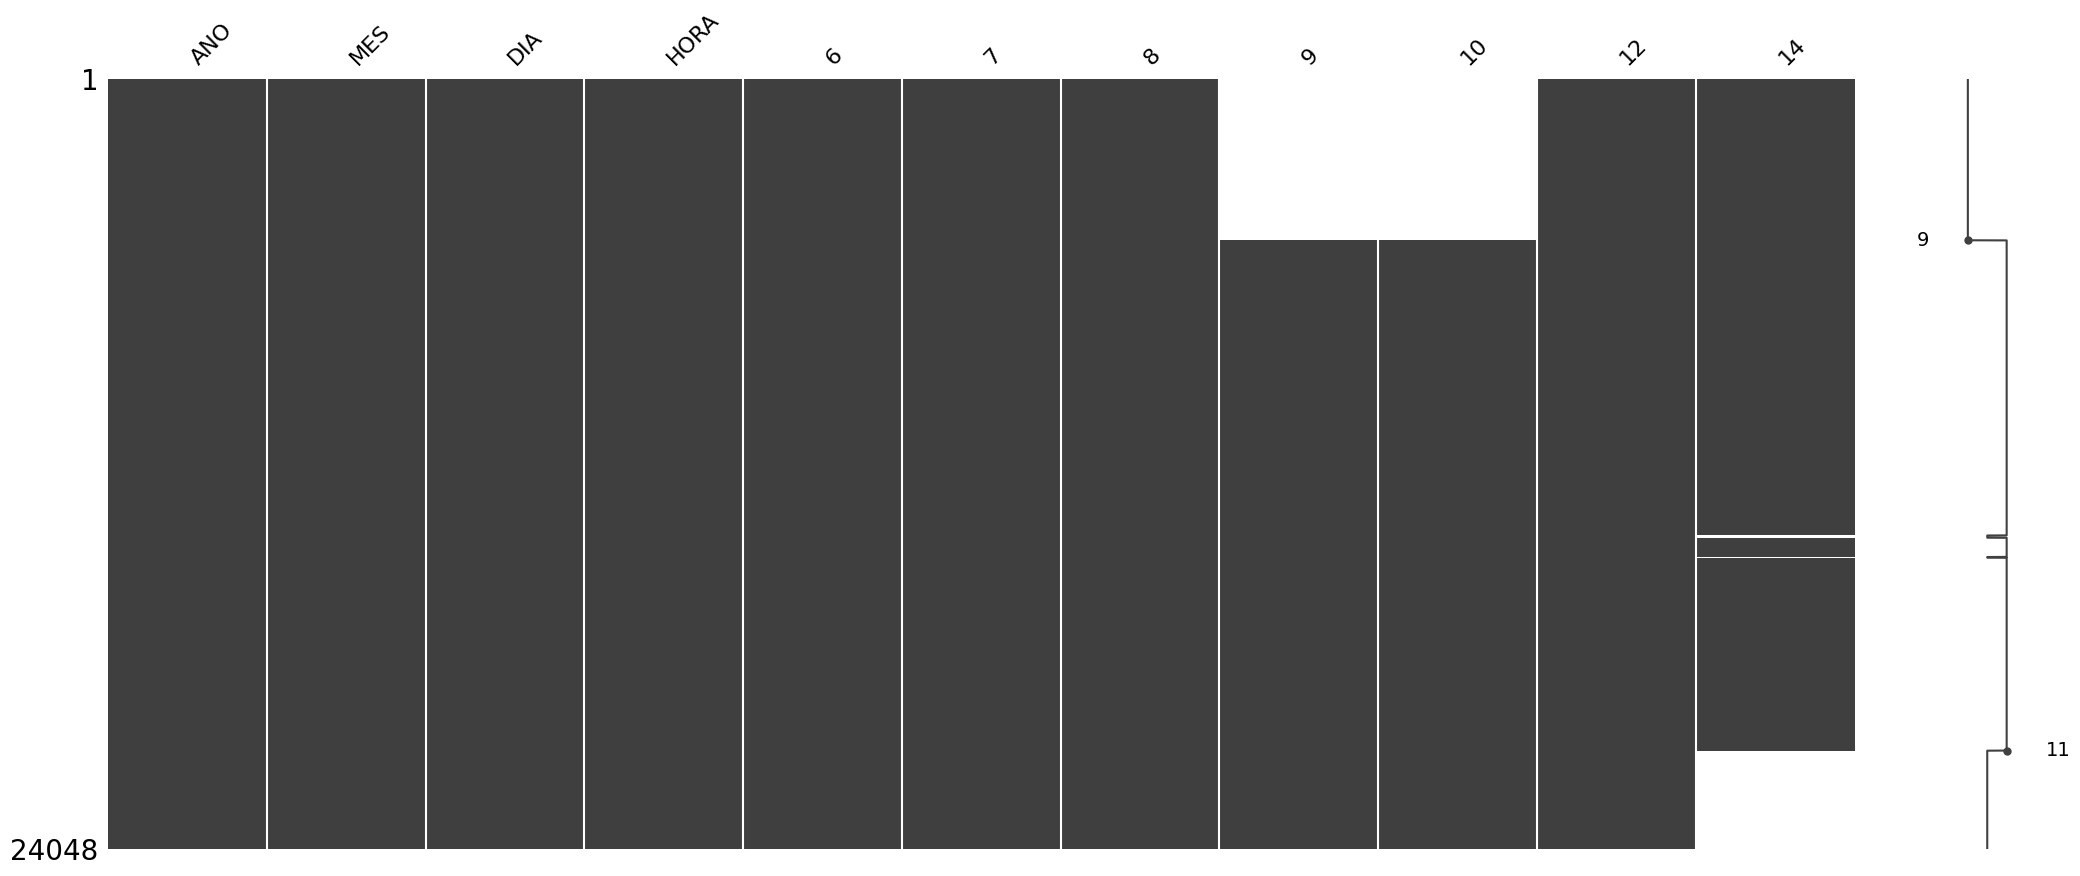

In [ ]:

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer( strategy='mean') #for median imputation replace 'mean' with 'median'
imp_mean.fit(df_conta[["6"]])
df_imputed = df_conta.copy()
df_imputed[["6"]]  = imp_mean.transform(df_conta[["6"]])
msno.matrix(df_imputed)

<a name="Tipos"></a>
## Tipos de nulos 

En [1976](https://www.jstor.org/stable/2335739) Donald B. Rubin distinguió 3 tipos de valores nulos:

* Si los datos perdidos se encuentran totalmente al azar en una columna y no depende del valor del resto de la fila, decimos que es  *missing completely at random* (MCAR). Nosotros les vamos a llamar Missing Independientes (MI). 

* Si el valor perdido está asociado a ciertos valores del resto de la fila tenemos valores *missing at random* (MAR), o Missing Dependientes (MD)

* En otro caso hablamos de *missing not at random* (MNAR): hay otras causas que no conocemos, no los vamos a considerar



<a name="Categorical"></a>
### MI versus MD en variables categóricas.

Podemos detectar si una columna depende de otra como (y por tanto es MAR y no MCAR) utilizando el test $\mathcal{X}^2$.
Empecemos por generar datos MI

In [ ]:
url = "https://raw.githubusercontent.com/RafaelCaballero/tdm/master/datos/contaminacionFinal.csv"
df_conta = pd.read_csv(url)
df_conta

,ANO,MES,DIA,HORA,6,7,8,9,10,12,14
0,2019,1,1,1,0.6,81,73,NaN,NaN,196,3.08
1,2019,1,1,2,0.8,124,82,NaN,NaN,272,3.05
2,2019,1,1,3,0.7,93,72,NaN,NaN,215,3.13
3,2019,1,1,4,0.6,86,66,NaN,NaN,198,3.02
4,2019,1,1,5,0.6,79,64,NaN,NaN,185,2.98
...,...,...,...,...,...,...,...,...,...,...,...
24043,2021,9,30,20,0.3,27,80,17.0,23.0,122,NaN
24044,2021,9,30,21,1.1,168,153,19.0,30.0,411,NaN
24045,2021,9,30,22,1.0,179,157,28.0,44.0,431,NaN
24046,2021,9,30,23,0.8,115,133,27.0,43.0,309,NaN


Nos inventamos una columna nueva que va a ser nula dependiendo del valor de un dado

In [ ]:
import numpy as np
df_conta["15"] = 0 # para crearlo
df_conta["dado"] = 0 # para crearlo

df_conta["dado"]  = np.random.choice([1, 2, 3, 4, 5, 6], len(df_conta), p=[1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

# nos quedamos con las filas en las que el dado tiene un 6
index = df_conta[df_conta["dado"]==6].index

# le ponemos nulos
df_conta.loc[index,"15"] = pd.NA
df_conta

,ANO,MES,DIA,HORA,6,7,8,9,10,12,14,15,dado
0,2019,1,1,1,0.6,81,73,NaN,NaN,196,3.08,0.0,4
1,2019,1,1,2,0.8,124,82,NaN,NaN,272,3.05,NaN,6
2,2019,1,1,3,0.7,93,72,NaN,NaN,215,3.13,0.0,4
3,2019,1,1,4,0.6,86,66,NaN,NaN,198,3.02,0.0,3
4,2019,1,1,5,0.6,79,64,NaN,NaN,185,2.98,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,2021,9,30,20,0.3,27,80,17.0,23.0,122,NaN,0.0,1
24044,2021,9,30,21,1.1,168,153,19.0,30.0,411,NaN,0.0,2
24045,2021,9,30,22,1.0,179,157,28.0,44.0,431,NaN,0.0,2
24046,2021,9,30,23,0.8,115,133,27.0,43.0,309,NaN,0.0,3


Para aplicar el test convertimos la columna que queremos examinar, la "15", en una nueva que vale 1 si es nulo y 0  en otro caso

In [ ]:
df_conta["15_missing"] = 0
indice_nulos = df_conta[df_conta['15'].isnull()].index
df_conta.loc[indice_nulos, "15_missing"] = 1
df_conta

,ANO,MES,DIA,HORA,6,7,8,9,10,12,14,15,dado,15_missing
0,2019,1,1,1,0.6,81,73,NaN,NaN,196,3.08,0.0,4,0
1,2019,1,1,2,0.8,124,82,NaN,NaN,272,3.05,NaN,6,1
2,2019,1,1,3,0.7,93,72,NaN,NaN,215,3.13,0.0,4,0
3,2019,1,1,4,0.6,86,66,NaN,NaN,198,3.02,0.0,3,0
4,2019,1,1,5,0.6,79,64,NaN,NaN,185,2.98,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,2021,9,30,20,0.3,27,80,17.0,23.0,122,NaN,0.0,1,0
24044,2021,9,30,21,1.1,168,153,19.0,30.0,411,NaN,0.0,2,0
24045,2021,9,30,22,1.0,179,157,28.0,44.0,431,NaN,0.0,2,0
24046,2021,9,30,23,0.8,115,133,27.0,43.0,309,NaN,0.0,3,0


Veamos primero cómo se relaciona con una columna nominal

In [ ]:
contingencias=pd.crosstab(index=df_conta.ANO,columns=df_conta["15_missing"])
contingencias

15_missing,0,1
ANO,,
2019,7249,1463
2020,7345,1439
2021,5448,1104


In [ ]:
from scipy.stats import chi2_contingency
 
# este es el test
ChiSqResult = chi2_contingency(contingencias)
ChiSqResult

Chi2ContingencyResult(statistic=0.7696465178663139, pvalue=0.6805709104043465, dof=2, expected_freq=array([[7260.7245509 , 1451.2754491 ],
       [7320.73053892, 1463.26946108],
       [5460.54491018, 1091.45508982]]))

Como $H_0$ = No hay correlación entre las variables, tenemos que como p>0.05 no podemos descartar no haya correlación, en principio asumimos MI. Miremos otra variable:

In [ ]:
df_conta["9_missing"] = 0
indice_nulos = df_conta[df_conta['9'].isnull()].index
df_conta.loc[indice_nulos, "9_missing"] = 1
contingencias=pd.crosstab(index=df_conta.ANO,columns=df_conta["9_missing"])
ChiSqResult = chi2_contingency(contingencias)
ChiSqResult

Chi2ContingencyResult(statistic=11224.507888805409, pvalue=0.0, dof=2, expected_freq=array([[6886.13173653, 1825.86826347],
       [6943.04191617, 1840.95808383],
       [5178.82634731, 1373.17365269]]))

Sale que sí hay correlación con el año; estamos en el caso de MD. Veamos si podemos ver esta relación gráficamente:

<AxesSubplot: xlabel='ANO', ylabel='Count'>

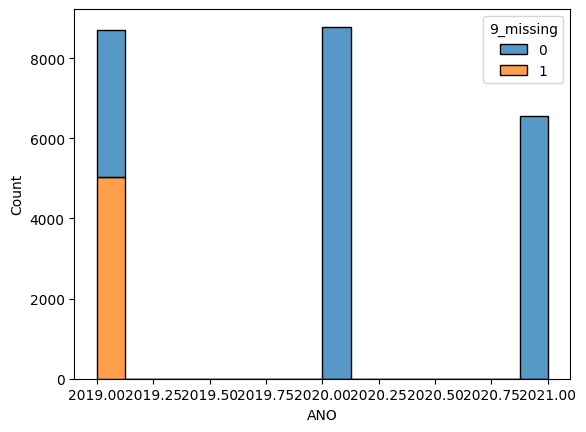

In [ ]:
sns.histplot(data=df_conta, hue="9_missing",x="ANO",stat="count", multiple="stack")

Cabría pensar en si merece la pena tratar aparte el año 2019

<a name="Ratio"></a>
### MI  versus MD en variables ratio

En este caso usaremos las correlaciones


In [ ]:
df_conta

,ANO,MES,DIA,HORA,6,7,8,9,10,12,14,15,dado,15_missing,9_missing
0,2019,1,1,1,0.6,81,73,NaN,NaN,196,3.08,0.0,4,0,1
1,2019,1,1,2,0.8,124,82,NaN,NaN,272,3.05,NaN,6,1,1
2,2019,1,1,3,0.7,93,72,NaN,NaN,215,3.13,0.0,4,0,1
3,2019,1,1,4,0.6,86,66,NaN,NaN,198,3.02,0.0,3,0,1
4,2019,1,1,5,0.6,79,64,NaN,NaN,185,2.98,0.0,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,2021,9,30,20,0.3,27,80,17.0,23.0,122,NaN,0.0,1,0,0
24044,2021,9,30,21,1.1,168,153,19.0,30.0,411,NaN,0.0,2,0,0
24045,2021,9,30,22,1.0,179,157,28.0,44.0,431,NaN,0.0,2,0,0
24046,2021,9,30,23,0.8,115,133,27.0,43.0,309,NaN,0.0,3,0,0


In [ ]:
df_conta.iloc[:,4:-3]

,6,7,8,9,10,12,14,15
0,0.6,81,73,NaN,NaN,196,3.08,0.0
1,0.8,124,82,NaN,NaN,272,3.05,NaN
2,0.7,93,72,NaN,NaN,215,3.13,0.0
3,0.6,86,66,NaN,NaN,198,3.02,0.0
4,0.6,79,64,NaN,NaN,185,2.98,0.0
...,...,...,...,...,...,...,...,...
24043,0.3,27,80,17.0,23.0,122,NaN,0.0
24044,1.1,168,153,19.0,30.0,411,NaN,0.0
24045,1.0,179,157,28.0,44.0,431,NaN,0.0
24046,0.8,115,133,27.0,43.0,309,NaN,0.0


In [ ]:
df_conta_num = df_conta.iloc[:,4:-3].copy()

for c in df_conta_num:
    indice_nulos = df_conta_num[df_conta_num[c].isnull()].index
    df_conta_num[c] = 0
    df_conta_num.loc[indice_nulos, c] = 1
df_conta_num


,6,7,8,9,10,12,14,15
0,0,0,0,1,1,0,0,0
1,0,0,0,1,1,0,0,1
2,0,0,0,1,1,0,0,0
3,0,0,0,1,1,0,0,0
4,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...
24043,0,0,0,0,0,0,1,0
24044,0,0,0,0,0,0,1,0
24045,0,0,0,0,0,0,1,0
24046,0,0,0,0,0,0,1,0


In [ ]:
# quitamos las columnas que no tienen unos
tiene_nulos = df_conta_num.sum()>0
tiene_nulos

6      True
7     False
8     False
9      True
10     True
12    False
14     True
15     True
dtype: bool

In [ ]:
df_conta_num = df_conta_num.iloc[:,tiene_nulos.values]
df_conta_num

,6,9,10,14,15
0,0,1,1,0,0
1,0,1,1,0,1
2,0,1,1,0,0
3,0,1,1,0,0
4,0,1,1,0,0
...,...,...,...,...,...
24043,0,0,0,1,0
24044,0,0,0,1,0
24045,0,0,0,1,0
24046,0,0,0,1,0


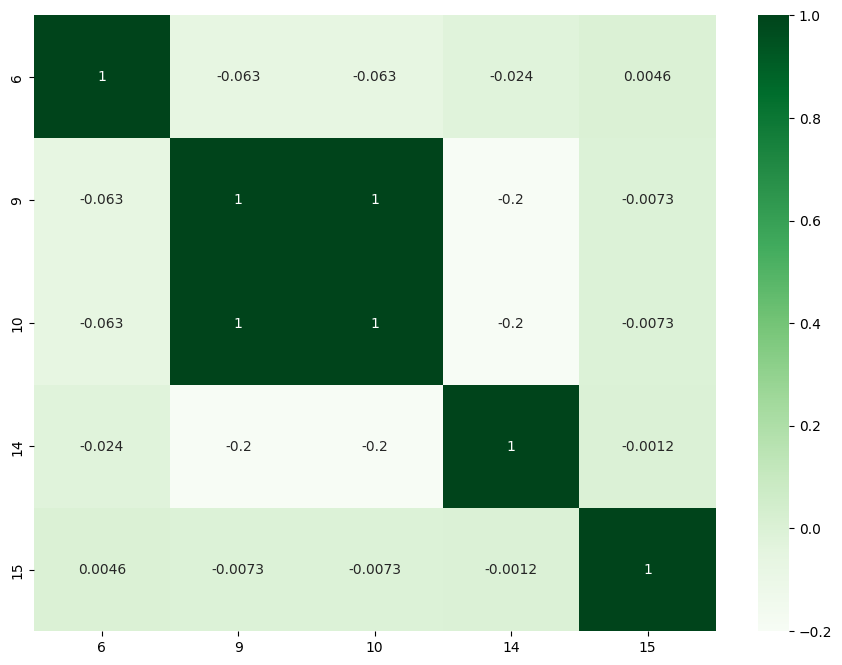

In [ ]:
import matplotlib.pyplot as plt
corr = df_conta_num.corr()
plt.figure(figsize=(11,8))
sns.heatmap(corr, cmap="Greens",annot=True)
plt.show()

Por tanto las columnas 9 y 10 parecen tener nulos justamente en las mismas posiciones y hablamos de MD, quizás tengan que estudiarse aparte

<a name="Bibliografía"></a>
## Bibliografía

[Visualización](https://towardsdatascience.com/visualizing-missing-values-in-python-is-shockingly-easy-56ed5bc2e7ea) con el ejemplo del titanic que hemos mostrado

[MCAR, MAR, MNAR](https://stefvanbuuren.name/fimd/sec-MCAR.html)

[El test $\mathcal{X}^2$ para distinguir MCAR de MAR](https://www.kaggle.com/code/yassirarezki/handling-missing-data-mcar-mar-and-mnar-part-i/notebook)